# Aula 40 - Random Forest (02-10-2025)

In [1]:

# === Utilitarios mínimos (acurácia, dataset de exemplo e plot) ===
import numpy as np
import matplotlib.pyplot as plt

def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())

def confusion_matrix(y_true, y_pred, n_classes=None):
    if n_classes is None:
        n_classes = int(max(y_true.max(), y_pred.max())) + 1
    M = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        M[int(t), int(p)] += 1
    return M

def make_moons(n=600, noise=0.25, seed=0):
    rng = np.random.RandomState(seed)
    angles = rng.rand(n//2) * np.pi
    x1 = np.c_[np.cos(angles), np.sin(angles)]
    x2 = x1 + [1.0, -0.5]
    X = np.vstack([x1, x2])
    y = np.r_[np.zeros(n//2, dtype=int), np.ones(n//2, dtype=int)]
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

def plot_decision_boundary(model, X, y, h=0.03, proba=False, title="Fronteira de decisão"):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if proba and hasattr(model, "predict_proba"):
        Z = model.predict_proba(grid)
        if Z.ndim == 2 and Z.shape[1] > 1: Z = Z[:,1]
    else:
        Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

def train_test_split(X, y, test_size=0.3, seed=0, stratify=True):
    rng = np.random.RandomState(seed)
    n = X.shape[0]
    idx = np.arange(n)
    if stratify:
        # estratificação estilo as que fizemos nos casos multiclasse anteriores
        idx_tr = []
        idx_te = []
        for c in np.unique(y):
            ii = np.where(y == c)[0]
            rng.shuffle(ii)
            t = int(round((1 - test_size) * len(ii)))
            idx_tr.append(ii[:t]); idx_te.append(ii[t:])
        idx_tr = np.concatenate(idx_tr); idx_te = np.concatenate(idx_te)
    else:
        rng.shuffle(idx)
        t = int(round((1 - test_size) * n))
        idx_tr, idx_te = idx[:t], idx[t:]
    return X[idx_tr], X[idx_te], y[idx_tr], y[idx_te]

def kfold_indices(n, k=5, shuffle=True, seed=0):
    rng = np.random.RandomState(seed)
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    folds = np.array_split(idx, k)
    for i in range(k):
        va = folds[i]
        tr = np.concatenate([folds[j] for j in range(k) if j != i])
        yield tr, va

def plot_lines(xs, ys_dict, xlabel="", ylabel="", title=""):
    plt.figure()
    for label, ys in ys_dict.items():
        plt.plot(xs, ys, marker="o", label=label)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

In [2]:
import numpy as np

def class_probs(y, n_classes=None):
    y = y.astype(int)
    if n_classes is None:
        if y.size == 0:
            return np.array([])
        n_classes = int(np.max(y)) + 1
    counts = np.bincount(y, minlength=n_classes).astype(float)
    s = counts.sum()
    return counts / s if s > 0 else counts

def gini(y):
    p = class_probs(y); return 1.0 - np.sum(p**2)

def entropy(y, eps=1e-12):
    p = class_probs(y); return -np.sum(p * np.log(p + eps))

def impurity(y, criterion="gini"):
    return gini(y) if criterion == "gini" else entropy(y)

def candidate_thresholds(x, max_candidates=50):
    x = np.asarray(x); uniq = np.unique(x)
    if uniq.size < 2: return np.array([])
    if uniq.size > max_candidates:
        qs = np.linspace(0, 1, max_candidates + 2)[1:-1]
        thr = np.unique(np.quantile(x, qs))
    else:
        thr = (uniq[:-1] + uniq[1:]) / 2.0
    return thr

def split_on_threshold(X, y, j, thr):
    xj = X[:, j]
    L = xj <= thr
    R = ~L
    return L, R

def weighted_impurity(yL, yR, criterion="gini"):
    m = yL.size + yR.size
    if m == 0: return 0.0
    return (yL.size * impurity(yL, criterion) + yR.size * impurity(yR, criterion)) / m

def best_split(X, y, *, criterion="gini", max_features=None, rng=None, max_candidates=50, stats=None):
    m, n = X.shape
    parent = impurity(y, criterion)
    if m == 0 or parent <= 0.0:
        return {"gain": 0.0, "feat": None, "thr": None}

    feats = np.arange(n)
    if max_features is not None:
        if isinstance(max_features, str) and max_features == "sqrt":
            k = max(1, int(np.sqrt(n)))
        elif isinstance(max_features, int):
            k = max(1, min(n, max_features))
        else:
            k = n
        if rng is None: rng = np.random.RandomState(0)
        feats = rng.choice(n, size=k, replace=False)

    best = {"gain": 0.0, "feat": None, "thr": None}
    cands = 0; valid = 0
    for j in feats:
        thrs = candidate_thresholds(X[:, j], max_candidates=max_candidates)
        cands += thrs.size
        for t in thrs:
            L, R = split_on_threshold(X, y, j, t)
            if not L.any() or not R.any():
                continue
            valid += 1
            gain = parent - weighted_impurity(y[L], y[R], criterion)
            if gain > best["gain"]:
                best = {"gain": float(gain), "feat": int(j), "thr": float(t)}
    if stats is not None:
        stats['cands'] = stats.get('cands', 0) + int(cands)
        stats['valid'] = stats.get('valid', 0) + int(valid)
    return best

def _leaf(y, n_classes):
    return {"type": "leaf", "proba": class_probs(y, n_classes=n_classes)}

def build_tree(X, y, depth, *, max_depth=8, min_samples_split=2,
               criterion="gini", max_features=None, rng=None, max_candidates=50, stats=None, n_classes=None):
    # Ensurse an effing fixed class dimension for the whole tree
    if n_classes is None:
        n_classes = int(np.max(y)) + 1 if y.size else 0

    if (depth >= max_depth) or (X.shape[0] < min_samples_split) or (impurity(y, criterion) == 0.0):
        return _leaf(y, n_classes)

    split = best_split(X, y, criterion=criterion, max_features=max_features, rng=rng,
                       max_candidates=max_candidates, stats=stats)
    if split["feat"] is None:
        return _leaf(y, n_classes)

    j, t = split["feat"], split["thr"]
    L, R = split_on_threshold(X, y, j, t)
    left = build_tree(X[L], y[L], depth+1, max_depth=max_depth, min_samples_split=min_samples_split,
                      criterion=criterion, max_features=max_features, rng=rng,
                      max_candidates=max_candidates, stats=stats, n_classes=n_classes)
    right = build_tree(X[R], y[R], depth+1, max_depth=max_depth, min_samples_split=min_samples_split,
                       criterion=criterion, max_features=max_features, rng=rng,
                       max_candidates=max_candidates, stats=stats, n_classes=n_classes)
    return {"type": "node", "feat": int(j), "thr": float(t), "left": left, "right": right, "gain": split["gain"]}

def predict_proba_row(node, x):
    while node["type"] != "leaf":
        node = node["left"] if x[node["feat"]] <= node["thr"] else node["right"]
    return node["proba"]

def predict_proba(tree, X):
    return np.vstack([predict_proba_row(tree, x) for x in X])

def predict(tree, X):
    P = predict_proba(tree, X); return np.argmax(P, axis=1)

class DecisionTree:
    def __init__(self, max_depth=8, min_samples_split=2, criterion="gini",
                 max_features=None, random_state=0, max_candidates=50):
        self.max_depth = max_depth; self.min_samples_split = min_samples_split
        self.criterion = criterion; self.max_features = max_features
        self.random_state = random_state; self.max_candidates = max_candidates
        self.rng_ = np.random.RandomState(random_state); self.tree_ = None
        self.n_classes_ = None
        self.stats_ = {}

    def fit(self, X, y):
        self.n_classes_ = int(np.max(y)) + 1 if y.size else 0
        self.stats_ = {}
        self.tree_ = build_tree(
            X, y, depth=0,
            max_depth=self.max_depth, min_samples_split=self.min_samples_split,
            criterion=self.criterion, max_features=self.max_features, rng=self.rng_,
            max_candidates=self.max_candidates, stats=self.stats_, n_classes=self.n_classes_
        )
        return self

    def predict_proba(self, X): return predict_proba(self.tree_, X)
    def predict(self, X): return np.argmax(self.predict_proba(X), axis=1)

def trace_path(tree, x):
    steps = []; node = tree
    while node["type"] != "leaf":
        j, t = node["feat"], node["thr"]; go_left = x[j] <= t
        steps.append((int(j), float(t), bool(go_left)))
        node = node["left"] if go_left else node["right"]
    return steps, node["proba"]

def pretty_print(node, depth=0):
    import numpy as _np
    indent = "  " * depth
    if node["type"] == "leaf":
        print(f"{indent}Leaf proba={_np.round(node['proba'], 3)}")
    else:
        j, t = node["feat"], node["thr"]
        print(f"{indent}if x[{j}] <= {t:.4f}:")
        pretty_print(node["left"], depth+1)
        print(f"{indent}else:  # x[{j}] > {t:.4f}")
        pretty_print(node["right"], depth+1)

In [3]:
import numpy as np
from copy import deepcopy

class BaggingClassifier:
    def __init__(self, base_estimator, n_estimators=100, bootstrap=True, random_state=0):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.estimators_ = []
        self.n_classes_ = None
        self.oob_score_ = None
        self.rng_ = np.random.RandomState(random_state)

    def _pad_proba(self, P):
        # ensures shape (n_samples, n_classes_)
        if P.shape[1] == self.n_classes_:
            return P
        out = np.zeros((P.shape[0], self.n_classes_), dtype=float)
        out[:, :P.shape[1]] = P
        return out

    def fit(self, X, y):
        n = X.shape[0]
        self.n_classes_ = int(np.max(y)) + 1
        self.estimators_ = []
        oob_votes = [ [] for _ in range(n) ]

        for _ in range(self.n_estimators):
            est = deepcopy(self.base_estimator)
            if self.bootstrap:
                idx = self.rng_.randint(0, n, size=n)
            else:
                idx = np.arange(n)
            est.fit(X[idx], y[idx])
            self.estimators_.append(est)

            if self.bootstrap:
                mask = np.ones(n, dtype=bool); mask[idx] = False
                if mask.any():
                    P = est.predict_proba(X[mask])
                    P = self._pad_proba(P)
                    for j, p in zip(np.where(mask)[0], P):
                        oob_votes[j].append(p)

        has = np.array([len(v) > 0 for v in oob_votes])
        if has.any():
            agg = np.zeros((has.sum(), self.n_classes_), dtype=float)
            ii = np.where(has)[0]
            for k, j in enumerate(ii):
                agg[k] = np.mean(oob_votes[j], axis=0)
            preds = np.argmax(agg, axis=1)
            self.oob_score_ = float((preds == y[has]).mean())
        return self

    def predict_proba(self, X):
        Ps = []
        for est in self.estimators_:
            P = est.predict_proba(X)
            P = self._pad_proba(P)
            Ps.append(P)
        return np.mean(Ps, axis=0)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

class RandomForest:
    def __init__(self, n_estimators=100, max_depth=8, min_samples_split=2, max_features="sqrt", random_state=0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.bagger_ = None
        self.oob_score_ = None

    def fit(self, X, y):
        base = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            criterion="gini",
                            max_features=self.max_features,
                            random_state=self.random_state)
        self.bagger_ = BaggingClassifier(base_estimator=base,
                                         n_estimators=self.n_estimators,
                                         bootstrap=True,
                                         random_state=self.random_state).fit(X, y)
        self.oob_score_ = self.bagger_.oob_score_
        return self

    def predict_proba(self, X): return self.bagger_.predict_proba(X)
    def predict(self, X): return self.bagger_.predict(X)


Single tree (max_depth=6) — Val acc: 0.7643


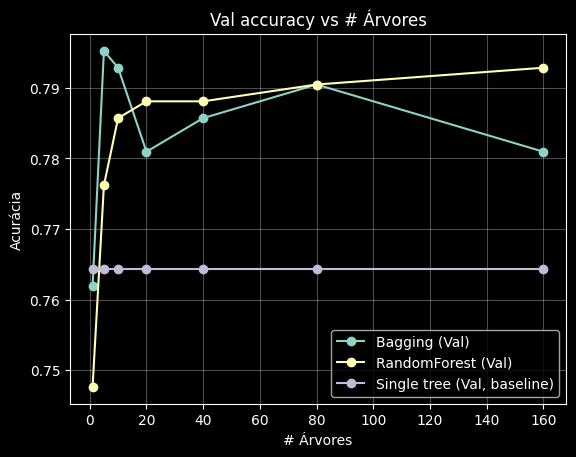

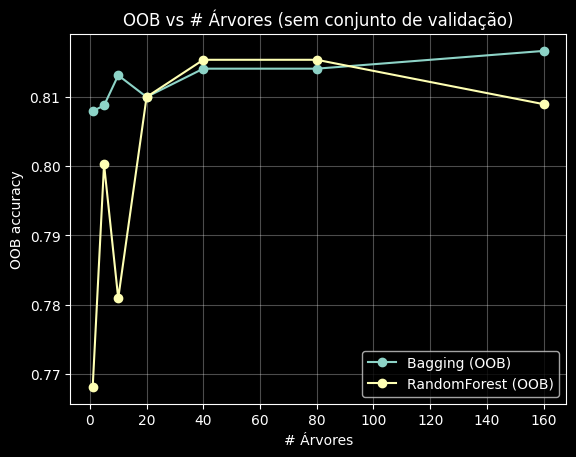

In [4]:
# Célula de exemplos

X, y = make_moons(n=1200, noise=0.30, seed=7)
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.35, seed=3, stratify=True)

# árvore base (pré-poda)
baseline = DecisionTree(max_depth=6, criterion="gini", random_state=0).fit(Xtr, ytr)
base_va = accuracy(yva, baseline.predict(Xva))
print("Single tree (max_depth=6) — Val acc:", round(base_va, 4))

grid = [1, 5, 10, 20, 40, 80, 160]
bag_va, bag_oob = [], []
rf_va,  rf_oob  = [], []

for n_est in grid:
    # Bagging (no subsampling)
    bag = BaggingClassifier(
        base_estimator=DecisionTree(max_depth=6, criterion="gini", random_state=0),
        n_estimators=n_est, bootstrap=True, random_state=0
    ).fit(Xtr, ytr)
    bag_va.append(accuracy(yva, bag.predict(Xva)))
    bag_oob.append(bag.oob_score_)

    # Random Forest (sqrt feature subsampling)
    rf = RandomForest(n_estimators=n_est, max_depth=6, max_features="sqrt", random_state=0).fit(Xtr, ytr)
    rf_va.append(accuracy(yva, rf.predict(Xva)))
    rf_oob.append(rf.oob_score_)

plot_lines(grid, {
    "Bagging (Val)": bag_va,
    "RandomForest (Val)": rf_va,
    "Single tree (Val, baseline)": [base_va]*len(grid),
}, xlabel="# Árvores", ylabel="Acurácia", title="Val accuracy vs # Árvores")

plot_lines(grid, {
    "Bagging (OOB)": bag_oob,
    "RandomForest (OOB)": rf_oob,
}, xlabel="# Árvores", ylabel="OOB accuracy", title="OOB vs # Árvores (sem conjunto de validação)")


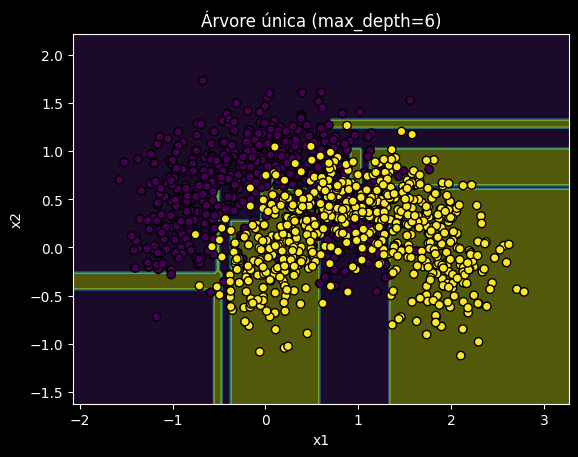

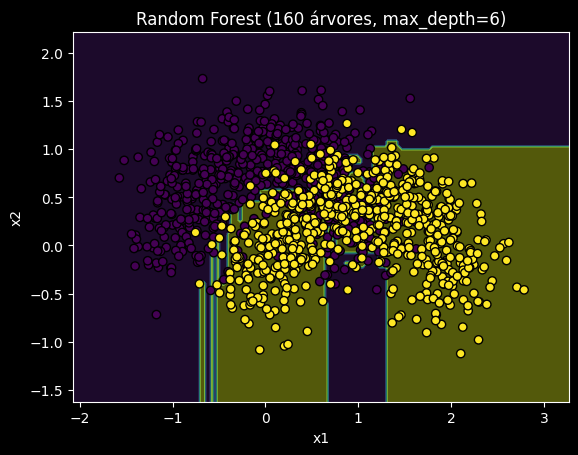

RF — Val acc: 0.7928571428571428 | OOB: 0.808974358974359


In [5]:
plot_decision_boundary(baseline, X, y, title="Árvore única (max_depth=6)")
rf_best = RandomForest(n_estimators=160, max_depth=6, max_features="sqrt", random_state=0).fit(Xtr, ytr)
plot_decision_boundary(rf_best, X, y, title="Random Forest (160 árvores, max_depth=6)")
print("RF — Val acc:", accuracy(yva, rf_best.predict(Xva)), "| OOB:", rf_best.oob_score_)


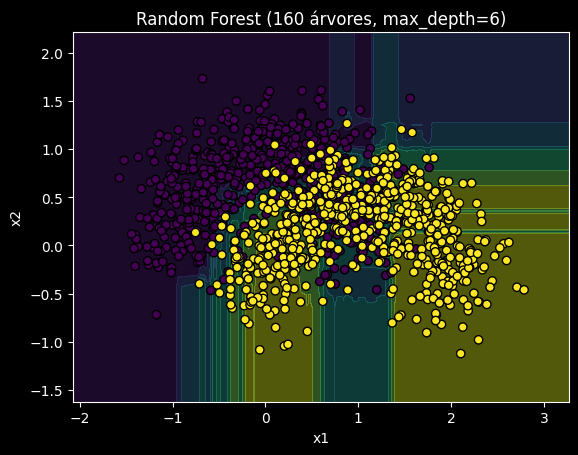

In [6]:
plot_decision_boundary(rf_best, X, y, proba=True, title="Random Forest (160 árvores, max_depth=6)")

Importâncias: [2.13174717 1.21912056]


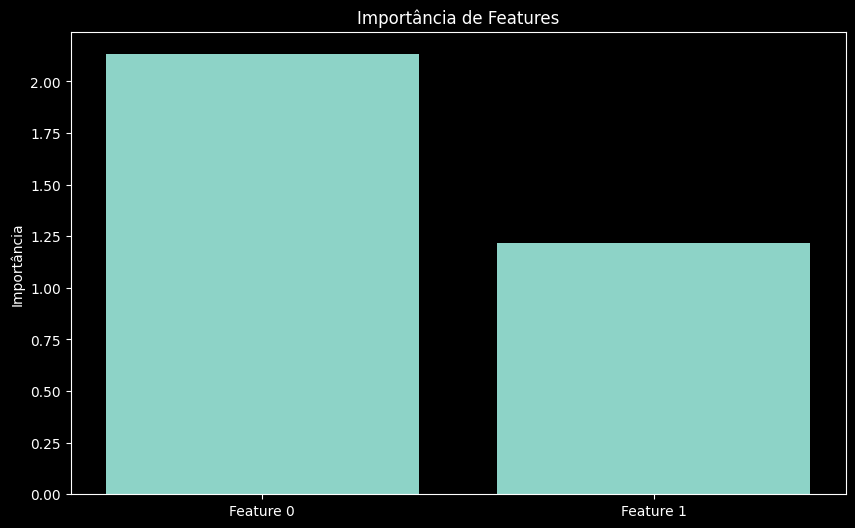

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Função recursiva para varrer a árvore e coletar os ganhos
def get_tree_importances(node, importances_arr):
    if node["type"] == "node":
        # Soma o ganho desse split para a importancia desse feature
        importances_arr[node["feat"]] += node["gain"]
        # Recursa para os ramos esquerdo e direto
        get_tree_importances(node["left"], importances_arr)
        get_tree_importances(node["right"], importances_arr)

# Conta principal
# Pega o número de features do dataset
n_features = Xtr.shape[1]

# Array que guarda todas as importâncias, incializado em zero
total_importances = np.zeros(n_features)

# Varre todas as árvores da floresta
for tree in rf_best.bagger_.estimators_:
    # importâncias dessa árvore
    single_tree_importances = np.zeros(n_features)
    # Chama a função que calcula as importâncias nessa árvore
    get_tree_importances(tree.tree_, single_tree_importances)
    # Soma a importância dessa árvore
    total_importances += single_tree_importances

# média entre todas as árvores
total_importances /= len(rf_best.bagger_.estimators_)

print("Importâncias:", total_importances)


feature_names = [f"Feature {i}" for i in range(n_features)]
plt.figure(figsize=(10, 6))
plt.bar(feature_names, total_importances)
plt.title("Importância de Features")
plt.ylabel("Importância")
plt.show()

# Exercícios

1. Na célula de exemplos, no Bagging Classifier, modifique bootstrap=True para bootstrap=False
- O que acontece o valor das acurácias de validação?
- Por que isso acontece? Como são as árvores em que o ensemble é treinado?

2. Na célula de exemplos, no classificador RandomForest, troque max_features="sqrt" por max_features=None.
- Como fica a acurácia de validação de RandomForest?
- Qual a diferença conceitual entre esse modelo de random forest que você rodou dessa forma e o BaggingClassifier?

3. Triplique a célula de exemplos, e em um delas troque todas a max_depths por 2. Em outra, troque todas a max_depth por 20.
- O que acontece quando as árvores base são extremamente rasas?
- Quando as árvores são profundas, o RandomForest consegue mitigar os problemas de overfitting?

4. Crie uma função capaz de calcular a importância de uma feature a partir da análise da perda de acurácia quando você embaralha uma feature.